# This script was used to see how electrodes correlate across subjects. See another from: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006769
#


In [ ]:
import numpy as np

from gesture.utils import get_epoch,get_good_channels
import matplotlib.pyplot as plt
import scipy.io
from gesture.config import *
import h5py
import pandas as pd
from gesture.utils import sub_sf_dict

In [ ]:
filename=meta_dir+'ele_anat_position.npy'
ele = np.load(filename,allow_pickle=True).item()
good_channels=get_good_channels()

In [ ]:
sid=2
info_dict=sub_sf_dict()
sf=info_dict[str(sid)]

tmin=0
tmax=0.5
epochs=get_epoch(sid, sf,scaler='no',trigger='EMG',tmin=tmin,tmax=tmax)
#epoch1=epochs['1']# 20 trials. 8001 time points per trial for 8s.
#epoch2=epochs['2']
epoch3=epochs['3'] # simple grasp
total_ch_number=len(epoch3.info.ch_names)
#epoch4=epochs['4']

In [ ]:
# mark bad channels
good_channel=good_channels['sid'+str(sid)] # start from 1 (Matlab)
good_channel=[i-1 for i in good_channel]
bad_channels_ind=[i for i in range(len(epoch3.ch_names)-7) if i not in good_channel]
bad_channels=[epoch3.ch_names[c] for c in bad_channels_ind]
epoch3.load_data()
epoch3.drop_channels(bad_channels)


### CC within trials from the same subject

In [ ]:
epoch=epoch3.copy().load_data().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
matrixes=[]
data=epoch.get_data(picks=['eeg'])
ch_number=data.shape[1]
for trial in data: # trial: (115, 1000)
    dataframe=pd.DataFrame(data=trial.transpose(),columns=[str(i) for i in range(ch_number)])
    matrix = dataframe.corr(method='pearson').to_numpy()
    matrix[np.diag_indices_from(matrix)] = 0.
    matrixes.append(matrix)
matrix_avg=np.average(np.asarray(matrixes),axis=0)

In [ ]:
a=matrix_avg.reshape(-1)
b=[abs(i) for i in a]
print(sum(b)/len(b))

In [ ]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrix_avg, cmap='Blues')
plt.colorbar()
plt.show()

### CC across trials for individual channel from the same subject

In [ ]:
epoch=epoch3.copy().load_data().filter(l_freq=0.1,h_freq=3,picks=['eeg'])
data=epoch.get_data(picks=['eeg']) # (20, 115, 1001)
ch_number=data.shape[1]

In [ ]:
matrixes=[]
ch_mean=[]
for ch in range(ch_number): # trial: (115, 1000)
    dataframe=pd.DataFrame(data=data[:,ch,:].squeeze().transpose())
    matrix = dataframe.corr(method='pearson').to_numpy()
    matrix[np.diag_indices_from(matrix)] = 0.
    matrixes.append(matrix)
    ch_mean.append(matrix.sum()/(20*20-20)) # diagonal is zero
matrix_avg=np.average(np.asarray(matrixes),axis=0)

In [ ]:
sum(ch_mean)/len(ch_mean)

In [ ]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrix_avg, cmap='Blues')
plt.title("CC between trials averaged across channels (within subject)")
plt.colorbar()
plt.show() # This plot actually meaningless, because each channel behavior very differently and this plot is the average across channels;

### look at each individual channel

In [ ]:
a=[abs(i) for i in ch_mean]
a.sort(reverse=True)
a

In [ ]:
[i for i, val in enumerate(ch_mean) if val==a[0]]

### The below blow is insightful: for one particular channel, CC among signals from different trials of this channel is not stable: waveform is not stable in different trials.  But the mean is positive,which means the waveform resemble to certain extent.

Visual checking confirm that movement onset time errors are below 100ms.

In [ ]:
%matplotlib inline
#%matplotlib qt
#%gui qt
plt.imshow(matrixes[81], cmap='Blues')
plt.title("channel with highest CC.")
plt.colorbar()
plt.show()

In [ ]:
ch_mean.index(max(ch_mean)) #maximum 0.68

## check CC across subjects. CC with trigger='EMG' is much higher than CC with trigger='EEG', which means group analysis is possible.

In [1]:
from gesture.group_analysis.util import calculate_CC
import matplotlib.pyplot as plt

sid1=2
sid2=4
sf1=1000
sf2=1000

2024-08-05 18:50:23 - Start Program

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [33]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EMG',re_ordered=True,random_shift=[0,500])

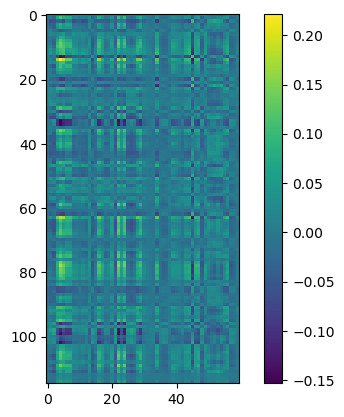

In [32]:
# trigger=EEG+random_shift
%matplotlib inline
fig,ax=plt.subplots()
im=ax.imshow(matrixes)
fig.colorbar(im)
plt.show()

In [19]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EMG',re_ordered=True)

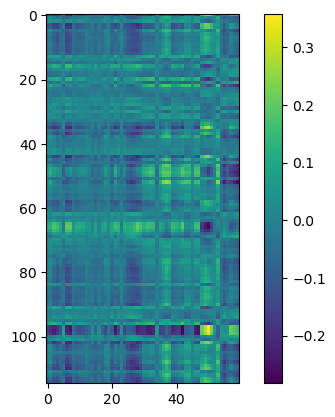

In [20]:
%matplotlib inline
# trigger=EMG
fig,ax=plt.subplots()
im=ax.imshow(matrixes)
fig.colorbar(im)
plt.show()

In [21]:
matrixes,ordered_ch_names=calculate_CC(sid1, sf1, sid2, sf2, f1=1, f2=3,trigger='EEG',re_ordered=True)

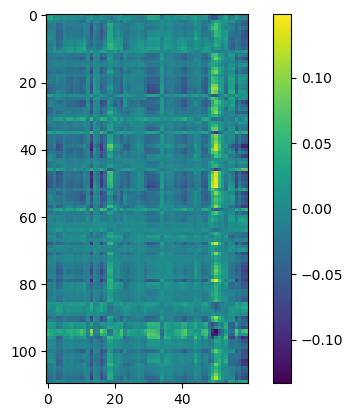

In [22]:
%matplotlib inline
# trigger=EMG
fig,ax=plt.subplots()
im=ax.imshow(matrixes)
fig.colorbar(im)
plt.show()